f=1, g=0. Domain: square [-1,1]^2 with moving crack from (0,0) to (1,alpha(t))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Settings
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0
T_MIN, T_MAX = 0.0, 1.0  

N_f = 4000       
N_b_outer = 800  
N_b_crack = 300  
N_ic = 1000      # initial condition points on domain at t=0
epochs = 300
lambda_bc = 1.0
lambda_ic = 1.0
lambda_zz = 1.0


def alpha(t):
    return (np.pi / 4.0) * torch.sin(2.0 * np.pi * t)

# phi(x,y,t)
def compute_phi_and_derivs(x, y, t):
    # phi(x,y,t) = sqrt( 1/2 * ( r - (x cos alpha + y sin alpha) ) )
    eps = 1e-12
    x = x.view(-1,1).clone().detach().to(device)
    y = y.view(-1,1).clone().detach().to(device)
    t = t.view(-1,1).clone().detach().to(device)

    # ？
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)

    a = alpha(t)
    r = torch.sqrt(torch.clamp(x**2 + y**2, min=eps))
    inside = 0.5 * (r - (x * torch.cos(a) + y * torch.sin(a)))
    inside = torch.clamp(inside, min=1e-14)
    phi = torch.sqrt(inside)

    # autograd 求 phi 對 (x,y,t) 的偏導  ##直接代式子應該更快？？
    grads = torch.autograd.grad(
        outputs=phi,
        inputs=(x, y, t),
        grad_outputs=torch.ones_like(phi),
        create_graph=True,
        retain_graph=True,
        allow_unused=True)

    phi_x = grads[0].view(-1,1) if grads[0] is not None else torch.zeros_like(phi)
    phi_y = grads[1].view(-1,1) if grads[1] is not None else torch.zeros_like(phi)
    phi_t = grads[2].view(-1,1) if grads[2] is not None else torch.zeros_like(phi)

    return phi, phi_x, phi_y, phi_t

Device: cpu


In [69]:
# MLP 
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) #????
                nn.init.zeros_(m.bias)

    def forward(self, inp):
        z = inp
        for layer in self.net[:-1]:
            z = self.activation(layer(z))
        z = self.net[-1](z)
        return z

# Derivatives of U w.r.t inputs (x,y,phi,t)
def partials_U_wrt_inputs(model, x, y, phi, t):
    # ensure column shapes
    x = x.view(-1,1)
    y = y.view(-1,1)
    phi = phi.view(-1,1)
    t = t.view(-1,1)

    inp = torch.cat([x, y, phi, t], dim=1).to(device)
    inp.requires_grad_(True)
    U = model(inp)  # (N,1)

    grads = torch.autograd.grad(U, inp, grad_outputs=torch.ones_like(U),
                                create_graph=True, retain_graph=True)[0]  # (N,4)
    U_x = grads[:,0:1]
    U_y = grads[:,1:2]
    U_z = grads[:,2:3]   
    U_t = grads[:,3:4]   
    return U, inp, U_x, U_y, U_z, U_t

def second_partials_U(model, inp, U_x, U_y, U_z):
    # inp shape (N,4)
    grad_Ux = torch.autograd.grad(U_x, inp, grad_outputs=torch.ones_like(U_x),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uy = torch.autograd.grad(U_y, inp, grad_outputs=torch.ones_like(U_y),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]

    U_xx = grad_Ux[:,0:1]
    U_xz = grad_Ux[:,2:3]
    U_yy = grad_Uy[:,1:2]
    U_yz = grad_Uy[:,2:3]
    U_zz = grad_Uz[:,2:3]

    return U_xx, U_yy, U_xz, U_yz, U_zz

# compute residual (u_t - Laplace u - f)
def compute_residual_time(model, x, y, t):
    # take phi and its derivs (using autograd internally)
    x_in = x.clone().detach().requires_grad_(True).to(device)
    y_in = y.clone().detach().requires_grad_(True).to(device)
    t_in = t.clone().detach().requires_grad_(True).to(device)

    phi, phi_x, phi_y, phi_t = compute_phi_and_derivs(x_in, y_in, t_in)

    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x_in, y_in, phi, t_in)
    U_xx, U_yy, U_xz, U_yz, U_zz = second_partials_U(model, inp, U_x, U_y, U_z)

    r = torch.sqrt(torch.clamp(x**2 + y**2, min=1e-12))
    laplace_U = U_xx + U_yy
    lap = laplace_U + 2.0 * (U_xz * phi_x + U_yz * phi_y) + (1/(4*r)) * U_zz

    # ut = U_z * phi_t + U_t
    ut = U_z * phi_t + U_t
    residual = ut - lap - 1.0
    return residual, U, U_zz, U_xz, U_yz

# compute tip constraint (at origin)
def compute_zz_uN(model, t_for_tip=None):
    if t_for_tip is None:
        t_for_tip = torch.tensor([[0.0]], dtype=torch.float64, device=device)
    x = torch.tensor([[0.0]], dtype=torch.float64, device=device)
    y = torch.tensor([[0.0]], dtype=torch.float64, device=device)
    phi, phi_x, phi_y, phi_t = compute_phi_and_derivs(x, y, t_for_tip)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x, y, phi, t_for_tip)
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_zz = grad_Uz[:,2:3]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]
    return (U_zz**2 + U_xz**2 + U_yz**2)

def compute_xyz_uN(model, x, y):
    phi = compute_phi(x, y)
    U, inp, U_x, U_y, U_z = partials_U_wrt_inputs(model, x, y, phi)
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]

    return U_xz**2+U_yz**2  # shape (N,1)

# sampling
def sample_collocation(N): 
    x = torch.rand(N*2,1) * (X_MAX - X_MIN) + X_MIN 
    y = torch.rand(N*2,1) * (Y_MAX - Y_MIN) + Y_MIN 
    t = torch.rand(N*2,1) * (T_MAX - T_MIN) + T_MIN 
    a = alpha(t) # shape (N*2,1) 
    # 裂縫直線 y = α(t)*x 點到直線距離 
    dist_to_crack = torch.abs(y - a * x) / torch.sqrt(1 + a**2) 
    # mask 
    mask_crack = (dist_to_crack < 1e-8) 
    x, y, t = x[~mask_crack][:N], y[~mask_crack][:N], t[~mask_crack][:N] 
    return x.to(device), y.to(device), t.to(device)

def sample_outer_boundary(N):
    per_side = max(4, N // 4)
    xs, ys = [], []

    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MIN)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MAX)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MIN)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MAX)

    x = torch.cat(xs, dim=0)[:N]
    y = torch.cat(ys, dim=0)[:N]
    t = torch.rand(N, 1, device=device, dtype=torch.float64) * (T_MAX - T_MIN) + T_MIN

    return x.to(device), y.to(device), t


def sample_crack_boundary(N):
    t = torch.rand(N, 1, device=device, dtype=torch.float64) * (T_MAX - T_MIN) + T_MIN
    x_vals = torch.linspace(0, 1, N, device=device, dtype=torch.float64).unsqueeze(1)
    y_vals = x_vals * alpha(t)
    return x_vals, y_vals, t

# model (input: x,y,phi,t) 
layers = [4, 64, 64, 1]
model = MLP(layers).to(device)    

In [70]:
# training points 
x_f, y_f, t_f = sample_collocation(N_f)
x_b_out, y_b_out, t_b_out = sample_outer_boundary(N_b_outer)
x_b_crack, y_b_crack, t_b_crack = sample_crack_boundary(N_b_crack)

# for BC we need time sampling (sample times for each boundary point)
#t_b_out = torch.rand_like(x_b_out) * (T_MAX - T_MIN) + T_MIN
#t_b_crack = torch.rand_like(x_b_crack) * (T_MAX - T_MIN) + T_MIN

# g=0 on boundary
g_b_out = torch.zeros_like(x_b_out, device=device)
g_b_crack = torch.zeros_like(x_b_crack, device=device)

# initial condition t=0: u(x,y,0)=0
x_ic, y_ic = sample_collocation(N_ic)[0:2]  # reuse sampler but we only take x,y
t_ic = torch.zeros_like(x_ic).to(device)
u0 = torch.zeros_like(x_ic).to(device)

# move tensors to device
x_b_out = x_b_out.to(device); y_b_out = y_b_out.to(device); t_b_out = t_b_out.to(device)
x_b_crack = x_b_crack.to(device); y_b_crack = y_b_crack.to(device); t_b_crack = t_b_crack.to(device)

# optimizer
optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, history_size=50, line_search_fn="strong_wolfe")

print("Start training (time-dependent PINN)")

loss_history = []
for ep in range(epochs):
    def closure():
        optimizer.zero_grad()
        # PDE residual loss (interior)
        residual_f, _, Uzz_f, Uxz_f, Uyz_f = compute_residual_time(model, x_f, y_f, t_f)
        loss_pde = torch.mean(residual_f**2)

        # boundary loss (outer boundary)
        phi_b_out, _, _, _ = compute_phi_and_derivs(x_b_out, y_b_out, t_b_out)
        inp_bc_out = torch.cat([x_b_out, y_b_out, phi_b_out, t_b_out], dim=1)
        u_bc_out = model(inp_bc_out)
        loss_bc_out = torch.mean((u_bc_out - g_b_out)**2)

        # boundary loss (crack)
        phi_b_crack, _, _, _ = compute_phi_and_derivs(x_b_crack, y_b_crack, t_b_crack)
        inp_bc_crack = torch.cat([x_b_crack, y_b_crack, phi_b_crack, t_b_crack], dim=1)
        u_bc_crack = model(inp_bc_crack)
        loss_bc_crack = torch.mean((u_bc_crack - g_b_crack)**2)

        # initial condition loss at t=0
        phi_ic, _, _, _ = compute_phi_and_derivs(x_ic, y_ic, t_ic)

        # 改成column vector
        x_ic_in = x_ic.view(-1,1)
        y_ic_in = y_ic.view(-1,1)
        t_ic_in = t_ic.view(-1,1)
        phi_ic_in = phi_ic.view(-1,1)
        inp_ic = torch.cat([x_ic_in, y_ic_in, phi_ic_in, t_ic_in], dim=1)
        u_ic_pred = model(inp_ic)
        loss_ic = torch.mean((u_ic_pred - u0)**2)

        ###
        #loss_zz = compute_zz_uN(model, t_for_tip=torch.tensor([[0.0]], device=device, dtype=torch.float64))
        #loss = loss_pde + lambda_bc * (loss_bc_out + loss_bc_crack) + lambda_ic * loss_ic + lambda_zz * loss_zz
        loss = loss_pde + lambda_bc * (loss_bc_out + loss_bc_crack) + lambda_ic * loss_ic 
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    loss_history.append(loss.item())

    if ep % 10 == 0 or ep == epochs-1:
        # quick validation (evaluate pde loss on held-out random collocation)
        x_val, y_val, t_val = sample_collocation(1000)
        res_val, _,_,_,_ = compute_residual_time(model, x_val, y_val, t_val)
        val_pde = torch.mean(res_val**2).item()
        print(f"Epoch {ep:4d} | TrainLoss {loss.item():.3e} | ValPDE {val_pde:.3e}")

print("Training finished.")


Start training (time-dependent PINN)
Epoch    0 | TrainLoss 1.200e+00 | ValPDE 4.640e-02
Epoch   10 | TrainLoss 1.767e-02 | ValPDE 5.014e-03
Epoch   20 | TrainLoss 1.245e-02 | ValPDE 4.028e-03
Epoch   30 | TrainLoss 9.847e-03 | ValPDE 4.724e-03
Epoch   40 | TrainLoss 8.090e-03 | ValPDE 4.168e-03
Epoch   50 | TrainLoss 6.812e-03 | ValPDE 2.991e-03
Epoch   60 | TrainLoss 5.549e-03 | ValPDE 4.515e-03
Epoch   70 | TrainLoss 4.325e-03 | ValPDE 3.425e-03
Epoch   80 | TrainLoss 3.520e-03 | ValPDE 2.365e-03
Epoch   90 | TrainLoss 3.099e-03 | ValPDE 1.750e-03
Epoch  100 | TrainLoss 2.657e-03 | ValPDE 3.059e-03
Epoch  110 | TrainLoss 2.337e-03 | ValPDE 5.144e-03
Epoch  120 | TrainLoss 2.146e-03 | ValPDE 2.369e-03
Epoch  130 | TrainLoss 1.975e-03 | ValPDE 1.218e-03
Epoch  140 | TrainLoss 1.805e-03 | ValPDE 1.590e-03
Epoch  150 | TrainLoss 1.674e-03 | ValPDE 1.392e-03
Epoch  160 | TrainLoss 1.544e-03 | ValPDE 2.048e-03
Epoch  170 | TrainLoss 1.446e-03 | ValPDE 9.344e-04
Epoch  180 | TrainLoss 1.36

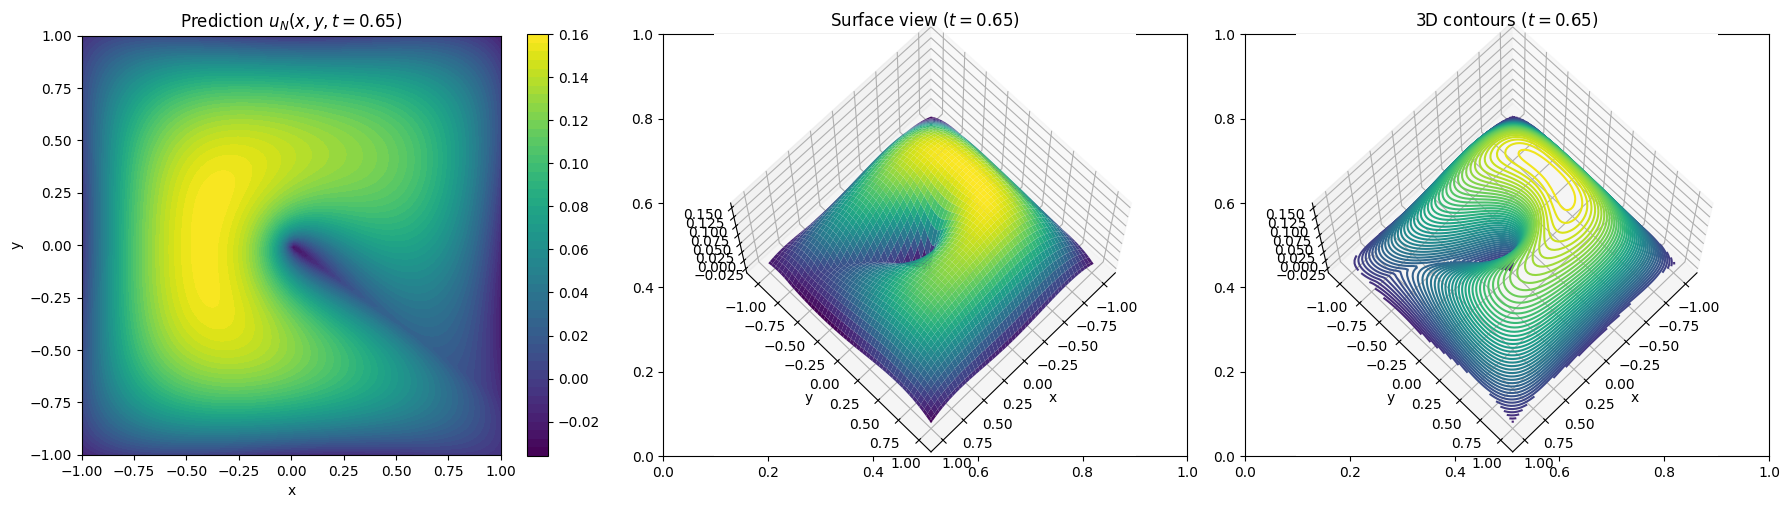

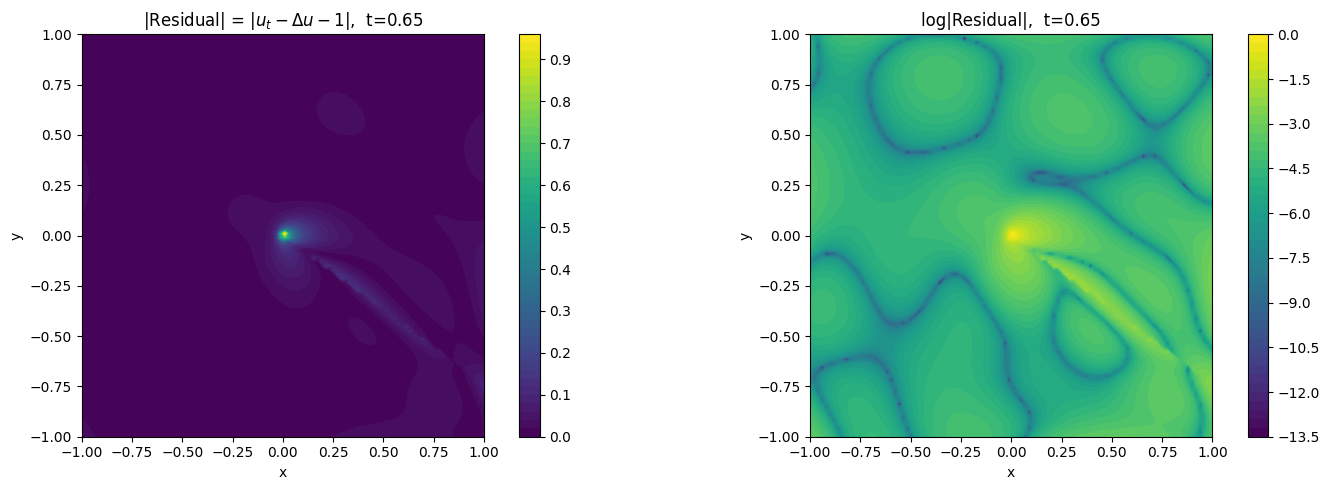

In [75]:
# test 
t0 = 0.65
nx = 100
xs = np.linspace(X_MIN, X_MAX, nx)
ys = np.linspace(Y_MIN, Y_MAX, nx)
Xg, Yg = np.meshgrid(xs, ys)

x_grid = torch.from_numpy(Xg.flatten()[:,None]).to(device).double()
y_grid = torch.from_numpy(Yg.flatten()[:,None]).to(device).double()
t_grid = torch.full_like(x_grid, t0).to(device)  # 全部時間都固定為 t0

# simpler phi (for inference / plotting, no grad) 
def compute_phi(x, y, t):
    eps = 1e-12
    x = x.view(-1,1).to(device)
    y = y.view(-1,1).to(device)
    t = t.view(-1,1).to(device)
    a = alpha(t)
    r = torch.sqrt(torch.clamp(x**2 + y**2, min=eps))
    inside = 0.5 * (r - (x * torch.cos(a) + y * torch.sin(a)))
    inside = torch.clamp(inside, min=1e-12)
    return torch.sqrt(inside)


with torch.no_grad():
    phi_grid = compute_phi(x_grid, y_grid, t_grid)

# 預測 u
with torch.no_grad():
    inp_grid = torch.cat([x_grid, y_grid, phi_grid, t_grid], dim=1)
    u_pred = model(inp_grid).cpu().numpy().reshape(nx, nx)

fig, axs = plt.subplots(1, 3, figsize=(18,5))

im0 = axs[0].contourf(Xg, Yg, u_pred, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title(f'Prediction $u_N(x,y,t={t0:.2f})$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')


ax1 = fig.add_subplot(132, projection='3d')
ax1.plot_surface(Xg, Yg, u_pred, cmap='viridis', edgecolor='none')
ax1.set_title(f'Surface view ($t={t0:.2f}$)')
ax1.set_xlabel('x'); ax1.set_ylabel('y')
ax1.view_init(elev=70, azim=45)

ax2 = fig.add_subplot(133, projection='3d')
ax2.contour3D(Xg, Yg, u_pred, 50, cmap='viridis')
ax2.set_title(f'3D contours ($t={t0:.2f}$)')
ax2.set_xlabel('x'); ax2.set_ylabel('y')
ax2.view_init(elev=70, azim=45)

plt.tight_layout()
plt.show()

# 殘差圖 
res, _, _, _, _ = compute_residual_time(model, x_grid, y_grid, t_grid)
abs_residual = torch.abs(res).detach().cpu().numpy().reshape(nx, nx)
log_abs_residual = np.log(abs_residual + 1e-12)  


fig, axs = plt.subplots(1, 2, figsize=(15,5))
im0 = axs[0].contourf(Xg, Yg, abs_residual, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title(f'|Residual| = |$u_t - \\Delta u - 1$|,  t={t0:.2f}')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); axs[0].set_aspect('equal')

im1 = axs[1].contourf(Xg, Yg, log_abs_residual, 50, cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title(f'log|Residual|,  t={t0:.2f}')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()
